In [1]:
import time

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import scipy

## Data

In [2]:
num_train_points = 1000
num_test_points = 200

In [3]:
data = np.load("../output/synthetic_data.npz")

train_x=data["train_x"]
train_y=data["train_y"]
test_x=data["test_x"]
test_y=data["test_y"]
small_noisy_x=data["small_noisy_x"]
large_noisy_x=data["large_noisy_x"]

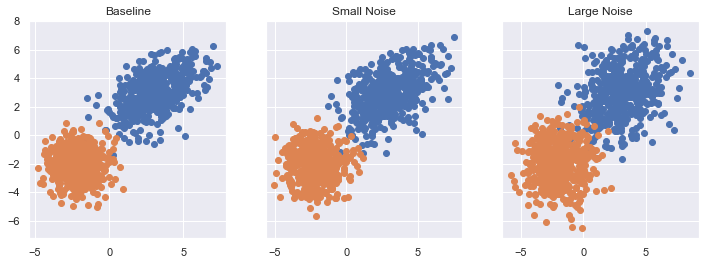

In [4]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 4))

class0 = train_y[:, 0] == 0
class1 = train_y[:, 0] == 1

train_xs = [train_x, small_noisy_x, large_noisy_x]
labels = ["Baseline", "Small Noise", "Large Noise"]

for i in range(3):
    axs[i].set_title(labels[i])
    axs[i].scatter(train_xs[i][class0, 0], train_xs[i][class0, 1])
    axs[i].scatter(train_xs[i][class1, 0], train_xs[i][class1, 1])

In [5]:
baseline_scores = np.load("../output/synthetic_baseline_scores.npz")
small_noisy_scores = np.load("../output/synthetic_small_noisy_scores.npz")
large_noisy_scores = np.load("../output/synthetic_large_noisy_scores.npz")

In [6]:
small_noise_distance = np.linalg.norm(small_noisy_x - train_x)
large_noise_distance = np.linalg.norm(large_noisy_x - train_x)

## Lipschitz Distance of Training Points

### Global

In [7]:
methods = ["influence", "theta_relatif", "grad_cos", "representer_values"]
labels = ["IF", "RIF", "GC", "RP"]

for i in range(4):
    
    baseline_idx = np.argsort(np.sum(baseline_scores[methods[i]], axis=1))[-1]
    small_noisy_idx = np.argsort(np.sum(small_noisy_scores[methods[i]], axis=1))[-1]
    large_noisy_idx = np.argsort(np.sum(large_noisy_scores[methods[i]], axis=1))[-1]  

    
    small_noise_ld = np.linalg.norm(
        small_noisy_x[small_noisy_idx] - train_x[baseline_idx]
    ) / small_noise_distance
    large_noise_ld = np.linalg.norm(
        large_noisy_x[large_noisy_idx] - train_x[baseline_idx]
    ) / large_noise_distance
    
    print("{:>3}: Small={:.3f}, Large={:.3f}".format(labels[i], small_noise_ld, large_noise_ld))

 IF: Small=0.171, Large=0.047
RIF: Small=0.013, Large=0.084
 GC: Small=0.204, Large=0.147
 RP: Small=0.040, Large=0.077


### Local

In [8]:
methods = ["influence", "theta_relatif", "grad_cos", "representer_values"]
labels = ["IF", "RIF", "GC", "RP"]

for i in range(4):
    
    baseline_idxs = np.argsort(baseline_scores[methods[i]], axis=1)[-1, :]
    small_noisy_idxs = np.argsort(small_noisy_scores[methods[i]], axis=1)[-1, :]
    large_noisy_idxs = np.argsort(large_noisy_scores[methods[i]], axis=1)[-1, :]
        
    small_noise_lds = np.linalg.norm(
        small_noisy_x[small_noisy_idxs] - train_x[baseline_idxs],
        axis=1
    ) / small_noise_distance
    large_noise_lds = np.linalg.norm(
        large_noisy_x[large_noisy_idxs] - train_x[baseline_idxs],
        axis=1
    ) / large_noise_distance
    
    print("{:>3}: Small={:.3f} \pm {:.3f}, Large={:.3f} \pm {:.3f}".format(
        labels[i],
        np.mean(small_noise_lds),
        np.std(small_noise_lds),
        np.mean(large_noise_lds),
        np.std(large_noise_lds),
    ))

 IF: Small=0.117 \pm 0.131, Large=0.102 \pm 0.069
RIF: Small=0.117 \pm 0.131, Large=0.102 \pm 0.069
 GC: Small=0.148 \pm 0.145, Large=0.110 \pm 0.066
 RP: Small=0.172 \pm 0.149, Large=0.078 \pm 0.064


## Rank Correlation

### Global

In [9]:
methods = ["influence", "theta_relatif", "grad_cos", "representer_values"]
labels = ["IF", "RIF", "GC", "RP"]

for i in range(4):
    
    baseline_sums = np.sum(baseline_scores[methods[i]], axis=1)
    small_noisy_sums = np.sum(small_noisy_scores[methods[i]], axis=1)
    large_noisy_sums = np.sum(large_noisy_scores[methods[i]], axis=1)

    small_spearman = scipy.stats.spearmanr(baseline_sums, small_noisy_sums).correlation
    large_spearman = scipy.stats.spearmanr(baseline_sums, large_noisy_sums).correlation
    
    print("{:>3}: Small={:.3f}, Large={:.3f}".format(labels[i], small_spearman, large_spearman))

 IF: Small=0.899, Large=0.686
RIF: Small=0.828, Large=0.609
 GC: Small=0.812, Large=0.611
 RP: Small=0.920, Large=0.723


### Local

In [10]:
methods = ["influence", "theta_relatif", "grad_cos", "representer_values"]
labels = ["IF", "RIF", "GC", "RP"]

for i in range(4):
    
    baseline_cols = baseline_scores[methods[i]].T
    small_noisy_cols = small_noisy_scores[methods[i]].T
    large_noisy_cols = large_noisy_scores[methods[i]].T

    small_spearman = [scipy.stats.spearmanr(baseline_cols[j], small_noisy_cols[j]).correlation for j in range(num_test_points)]
    large_spearman = [scipy.stats.spearmanr(baseline_cols[j], large_noisy_cols[j]).correlation for j in range(num_test_points)]
    
    print("{:>3}: Small={:.3f} \pm {:.3f}, Large={:.3f} \pm {:.3f}".format(
        labels[i],
        np.mean(small_spearman),
        np.std(small_spearman),
        np.mean(large_spearman),
        np.std(large_spearman),
    ))

 IF: Small=0.887 \pm 0.034, Large=0.651 \pm 0.093
RIF: Small=0.834 \pm 0.013, Large=0.602 \pm 0.076
 GC: Small=0.829 \pm 0.016, Large=0.604 \pm 0.081
 RP: Small=0.907 \pm 0.013, Large=0.693 \pm 0.030


## Distance of Raw Scores

### Global

In [11]:
methods = ["influence", "theta_relatif", "grad_cos", "representer_values"]
labels = ["IF", "RIF", "GC", "RP"]

for i in range(4):
    norm = np.linalg.norm(np.sum(baseline_scores[methods[i]], axis=1))
    baseline_sums = np.sum(baseline_scores[methods[i]], axis=1) / norm
    small_noisy_sums = np.sum(small_noisy_scores[methods[i]], axis=1) / norm
    large_noisy_sums = np.sum(large_noisy_scores[methods[i]], axis=1) / norm
    
    small_noise_dist = np.linalg.norm(small_noisy_sums - baseline_sums)
    large_noise_dist = np.linalg.norm(large_noisy_sums - baseline_sums)
    
    print("{:>3}: Small={:.3f}, Large={:.3f}".format(labels[i], small_noise_dist, large_noise_dist))

 IF: Small=0.738, Large=1.566
RIF: Small=0.540, Large=0.907
 GC: Small=0.575, Large=1.015
 RP: Small=0.631, Large=1.234


### Local

In [12]:
methods = ["influence", "theta_relatif", "grad_cos", "representer_values"]
labels = ["IF", "RIF", "GC", "RP"]

for i in range(4):
    
    norm = np.linalg.norm(baseline_scores[methods[i]], axis=0)
    baseline_cols = (baseline_scores[methods[i]] / norm).T
    small_noisy_cols = (small_noisy_scores[methods[i]] / norm).T
    large_noisy_cols = (large_noisy_scores[methods[i]] / norm).T
    
    small_noise_dists = np.linalg.norm(small_noisy_cols - baseline_cols, axis=1)
    large_noise_dists = np.linalg.norm(large_noisy_cols - baseline_cols, axis=1)
    
    print("{:>3}: Small={:.3f} \pm {:.3f}, Large={:.3f} \pm {:.3f}".format(
        labels[i],
        np.mean(small_noise_dists),
        np.std(small_noise_dists),
        np.mean(large_noise_dists),
        np.std(large_noise_dists),
    ))

 IF: Small=0.736 \pm 0.031, Large=1.393 \pm 0.200
RIF: Small=0.552 \pm 0.024, Large=0.931 \pm 0.276
 GC: Small=0.568 \pm 0.028, Large=0.869 \pm 0.106
 RP: Small=0.651 \pm 0.034, Large=1.312 \pm 0.115
